# Distinguishing-News-Sentiments

- Fox news had a more noticable positive polarity compared to other news outlets. This may because they are a conservative news outlet, and we have a current conservative president. The other polarity scores were relativly close.
- The BBC had the longest average time in between tweets, as the shortest were achieved by Fox, CBS and CNN. This can be because the target audience of US based news outlets use twitter more than those in the UK.
- Overall, there was slightly more negative and neutral polarity scores than positive. This may because positive news stories don't always 



In [1]:
#dependences
import tweepy
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone

In [2]:
#import vader for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
# Twitter API Keys
consumer_key = "r13GARnSlIYpn4rT8Cky7lggU"
consumer_secret = "jNzYyOlz2cKvN5hqTetJGpa9C2HxeTGrq6FLb6J1VlZRwkFMg8"
access_token = "365121943-MtrTOA6FQ7ZXgkDM70f4fbrvmjI5vtucwok4nd8U"
access_token_secret = "7LiSAbsWOyLjpagesrBduFvL82NcP4rrdodlMfzCM9Q0r"

In [4]:
#autheticate
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [39]:
#make dictionary of twitter SNs, network names, and colors for graphs
news_labels = {'CNN': 
                   {'name': 'CNN', 
                    'color': 'blue'}, 
               'BBC': 
                   {'name': 'BBC World News', 
                    'color': 'red'}, 
               'CBSNews': 
                   {'name': 'CBS', 
                    'color': 'lightblue'},
               'nytimes': 
                   {'name': 'New York Times', 
                    'color': 'green'}, 
               'FoxNews': 
                   {'name': 'Fox', 
                    'color': 'yellow'}}

In [40]:
news_dict = {
    "Screen Name": [],
    "Tweet": [],
    "Date": [],
    "Compound Score": [],
    "Positive Score": [],
    "Negative Score": [],
    "Neutral Score": [],
    "Tweets Ago": []
}

In [41]:
# loop through SNs in dictionary
for news_org in news_labels.keys():
    tweets_ago = 1 #counts tweets 1 - most current 100 - least current, resets for each news_org
    for x in range(5): # loops through 5 pages of 20 tweets
        if x == 0:
            response = api.user_timeline(news_org, count = 20) #most recent 20 tweets
        else:
            response = api.user_timeline(news_org, max_id = end_id-1 , count = 20) # next 20 most recent tweets each time
        for tweet in response: # disects each tweet and pulls necessary info
            text = tweet['text'] #tweet text
            date = tweet['created_at'] #time created
            convert_date = datetime.strptime(date, "%a %b %d %H:%M:%S %z %Y") #converts date to sortable time
            user = tweet['user']['screen_name'] #SN of user
            end_id = tweet['id'] # gets id of tweet to be used in loop for next 20 results
            scores = analyzer.polarity_scores(text) # scores the text in tweet using VADER
            news_dict['Screen Name'].append(user) # adds SN to dict
            news_dict['Tweet'].append(text) # adds tweet text to dict
            news_dict['Date'].append(convert_date) # adds converted date to dict
            news_dict['Compound Score'].append(scores['compound']) 
            news_dict['Positive Score'].append(scores['pos'])
            news_dict['Negative Score'].append(scores['neg'])
            news_dict['Neutral Score'].append(scores['neu'])
            news_dict['Tweets Ago'].append(tweets_ago)
            tweets_ago += 1 # sets tweets ago count for next record

In [42]:
#converts to dataframe
news_df = pd.DataFrame(news_dict)

news_df.head()

,Compound Score,Date,Negative Score,Neutral Score,Positive Score,Screen Name,Tweet,Tweets Ago
0,-0.7351,2018-03-07 00:38:15+00:00,0.256,0.744,0.000,CNN,Van Jones on reports Trump emboldened Scaramuc...,1
1,-0.4588,2018-03-07 00:36:03+00:00,0.222,0.778,0.000,CNN,"Dumpster fire (noun): ""An utterly calamitous o...",2
2,0.6369,2018-03-07 00:31:07+00:00,0.000,0.811,0.189,CNN,Senate Majority Leader Mitch McConnell on the ...,3
3,0.0000,2018-03-07 00:26:03+00:00,0.000,1.000,0.000,CNN,A 'man of mystery' with ties to Donald Trump’s...,4
4,-0.3612,2018-03-07 00:20:34+00:00,0.111,0.889,0.000,CNN,Dow futures fell more than 300 points after Ga...,5


In [11]:
len(news_df)

500

In [ ]:
news_df.to_csv('Output_CSVs/news_analysis.csv')


In [18]:
by_org = news_df.groupby('Screen Name')

pos_count = news_df[news_df['Compound Score'] > 0].groupby('Screen Name')['Compound Score'].count()
neg_count = news_df[news_df['Compound Score'] < 0].groupby('Screen Name')['Compound Score'].count()
neu_count = news_df[news_df['Compound Score'] == 0].groupby('Screen Name')['Compound Score'].count()

polarity_df = pd.DataFrame({
    "Positive Compound Scores": pos_count,
    "Negative Compound Scores": neg_count,
    "Neutral Compound Scores": neu_count,
    "Total": pos_count + neg_count + neu_count
})
polarity_df

,Negative Compound Scores,Neutral Compound Scores,Positive Compound Scores,Total
Screen Name,,,,
BBCWorld,37,44,19,100
CBSNews,32,31,37,100
CNN,38,35,27,100
FoxNews,31,28,41,100
nytimes,37,34,29,100


In [19]:
neg_sum = polarity_df['Negative Compound Scores'].sum()
neu_sum = polarity_df['Neutral Compound Scores'].sum()
pos_sum = polarity_df['Positive Compound Scores'].sum()
total = neg_sum + pos_sum + neu_sum

totals_df = pd.DataFrame({
    "Total Negative": [neg_sum],
    "Total Positive": pos_sum,
    "Total Neutral": neg_sum,
    "Total": total
})

totals_df

,Total,Total Negative,Total Neutral,Total Positive
0,500,175,175,153


In [20]:
time_max = by_org['Date'].max()
time_min = by_org['Date'].min()
time_diff = time_max - time_min
time_diff

avg_time_bt_tweets = time_diff/100
time_df = pd.DataFrame({
    "Time Span Between 1 and 100 Tweets Ago": time_diff,
    "Average Time Between Tweets": avg_time_bt_tweets
})

time_df

,Average Time Between Tweets,Time Span Between 1 and 100 Tweets Ago
Screen Name,,
BBCWorld,00:21:42.540000,1 days 12:10:54
CBSNews,00:07:58.100000,0 days 13:16:50
CNN,00:07:15.870000,0 days 12:06:27
FoxNews,00:07:49.110000,0 days 13:01:51
nytimes,00:12:44.990000,0 days 21:14:59


In [21]:
time_max = by_org['Date'].max()
time_min = by_org['Date'].min()
time_diff = time_max - time_min
time_diff

avg_time_bt_tweets = time_diff/100
time_df = pd.DataFrame({
    "Time Span Between 1 and 100 Tweets Ago": time_diff,
    "Average Time Between Tweets": avg_time_bt_tweets
})

time_df

,Average Time Between Tweets,Time Span Between 1 and 100 Tweets Ago
Screen Name,,
BBCWorld,00:21:42.540000,1 days 12:10:54
CBSNews,00:07:58.100000,0 days 13:16:50
CNN,00:07:15.870000,0 days 12:06:27
FoxNews,00:07:49.110000,0 days 13:01:51
nytimes,00:12:44.990000,0 days 21:14:59


In [23]:
#finds date of most recent and least recent tweet
date_max = news_df['Date'].max().replace(tzinfo=timezone.utc).astimezone(tz = 'US/Eastern').strftime('%D: %r') + " (ET)"
date_min = date_min = news_df['Date'].min().replace(tzinfo=timezone.utc).astimezone(tz = 'US/Eastern').strftime('%D: %r') + " (ET)"

In [43]:
#plots scatter of news ords in dictionary with appr. colors and names from news_labels dict
plt.figure(figsize = (15,10))
plt.xlim(102,-2, -1)
plt.ylim(-1,1)
plt.title('Sentiment Analysis of the Last 100 Tweets of Popular News Outlets \n Samples taken from %s to %s' % (date_min, date_max),
         fontdict = {'fontsize': 20})
for news_org in news_labels.keys():
    df = news_df[news_df['Screen Name'] == news_org]
    yvals = df['Compound Score']
    xvals = df['Tweets Ago']
    labels = news_labels[news_org]['name'] #names from news_labels dict
    colors = news_labels[news_org]['color'] # colors from news labels dict
    plt.scatter(xvals,yvals, label = labels, s = 125, color = colors, edgecolor = 'black')
    plt.legend(bbox_to_anchor = (1,1),
           frameon = True, 
           edgecolor = 'black', 
           facecolor = 'white',
           title = "News Outlet")
plt.xlabel('Tweets Ago',
          fontdict = {'fontsize': 16})
plt.ylabel('Tweet Polarity',
          fontdict = {'fontsize': 16})

Text(0,0.5,'Tweet Polarity')

In [ ]:
plt.savefig('Output_Graphs/tweets_scatter.png', bbox_inches = 'tight')


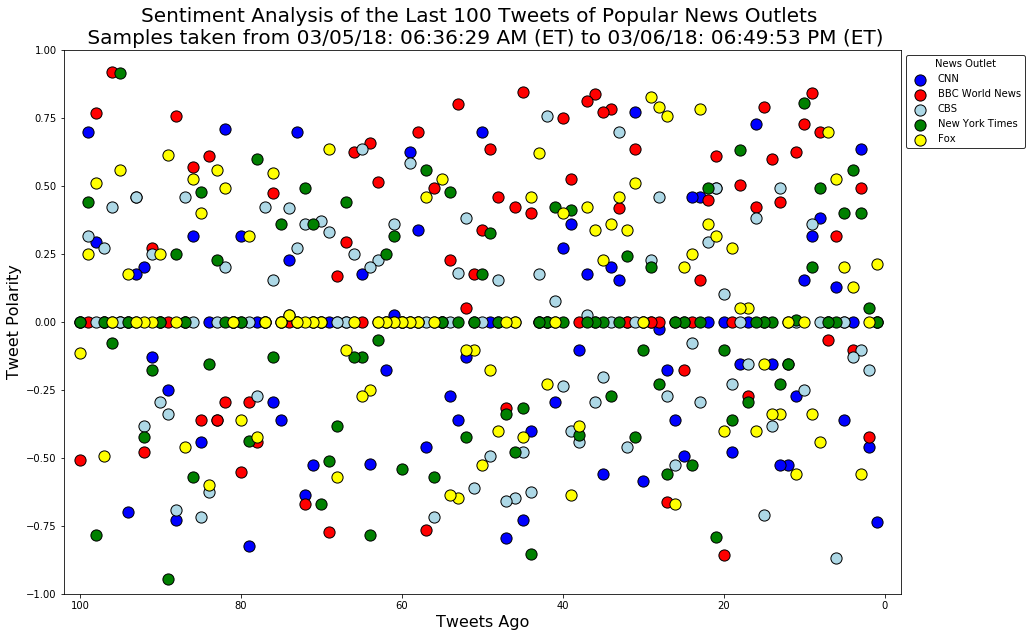

In [44]:
plt.show()

In [37]:
# group by SN and find average of each group
scores_by_org = news_df.groupby('Screen Name')['Compound Score'].mean()

# bar chart of mean scores labels
plt.title('Average Sentiment of the Last 100 Tweets of Popular News Outlets \n Samples taken from %s to %s' % (date_min, date_max))
plt.xlabel('News Network')
plt.ylabel('Average Polarity Score')

# list from group by network
xlabels = scores_by_org.index
# location of each bar
xvals = np.arange(len(scores_by_org))

count = 0 # for x coord location of value label

#create each value label
for score in scores_by_org: 
    if score < 0: #for neg scores, put label under
        height = score - .01
    else: # for + scores, put label above
        height = score + .01
    plt.text(count, height, str(round(score, 2)), ha = 'center', va = 'center')
    count += 1
plt.bar(xvals, 
        scores_by_org, 
        color = [news_labels[x]['color'] for x in xlabels], # sets colors from news_labels dict from xlabel list
        tick_label = [news_labels[x]['name'] for x in xlabels]) # sets x tick labels from news_la

<Container object of 5 artists>

In [ ]:
plt.savefig('Output_Graphs/average_scores.png')

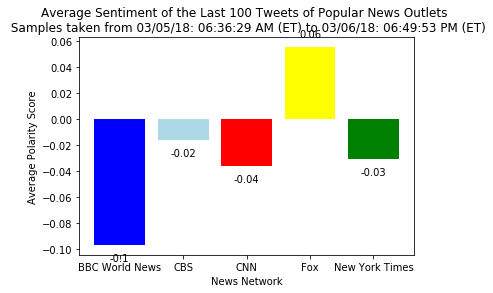

In [38]:
plt.show()